In [1]:
import cv2 as cv
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import math  
import numpy as np
from scipy import ndimage
from scipy.ndimage.filters import convolve
from skimage import feature

# Canny Edge Detector

In [2]:
image = cv.imread('image-65.jpg')
mask = cv.imread('mask-65.png')

#resize image and mask
image_resized = cv.resize(image, (640, 480))
mask_resized = cv.resize(mask, (640, 480))

#convert to greyscale
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_gray = cv.cvtColor(image_resized, cv.COLOR_BGR2GRAY, 0)

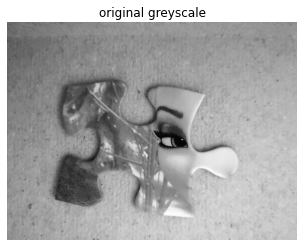

In [3]:
plt.axis("off")
plt.imshow(image_gray, cmap='gray')
plt.title("original greyscale")
plt.show()

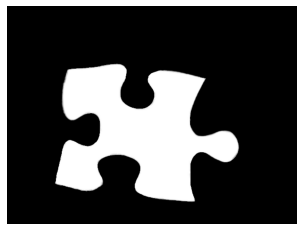

In [4]:
plt.axis("off")
plt.imshow(mask_resized)
plt.show()

# Noise Removal with Gaussian filtering

In [5]:
def gaussian_filter(img, sigma = 4):
    truncate = 4.0
    radius = math.floor(truncate*sigma +0.5)
    size = 2*radius +1
    print(size)
    blur = cv.GaussianBlur(img,(size,size),0)
    
    return blur

In [6]:
blurred = gaussian_filter(image_gray)

33


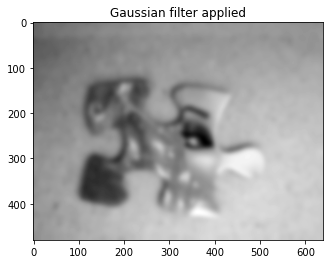

In [7]:
plt.imshow(blurred,cmap='gray')
plt.title("Gaussian filter applied")
plt.show()

# Calculate intensity gradiant of the image

In [8]:
def intensities(blurred_img):
    
#     S_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
#     S_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    sobelx = cv.Sobel(blurred_img,cv.CV_64F,1,0,ksize=9)
    sobely = cv.Sobel(blurred_img,cv.CV_64F,0,1,ksize=9)

#     I_x = ndimage.filters.convolve(blurred_img, S_x)
#     I_y = ndimage.filters.convolve(blurred_img, S_y)

    G = np.hypot(sobelx, sobely)
    G = G / G.max() * 255
    theta = np.arctan2(sobely, sobelx)
    return (G, theta, sobelx, sobely)

(Text(0.5, 1.0, 'Sobel Y'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

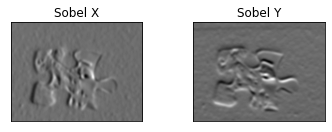

In [9]:
sobelx, sobely = intensities(blurred)[2:]
plt.subplot(2,2,1),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

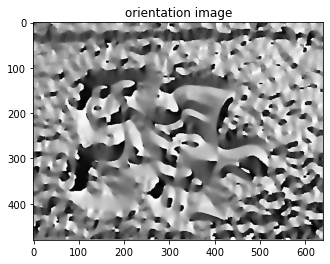

In [10]:
plt.imshow(intensities(blurred)[1],cmap='gray')
plt.title("orientation image")
plt.show()

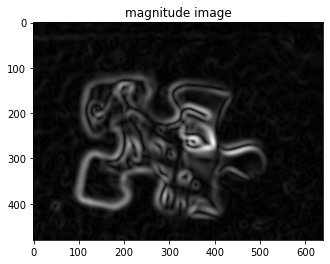

In [11]:
plt.imshow(intensities(blurred)[0],cmap='gray')
plt.title("magnitude image")
plt.show()

# non-maximum suppression

In [12]:
def non_max_suppression(img, D): #takes gradient matrix and theta matrix
    
# Create a matrix initialized to 0 of the 
# same size of the original gradient intensity matrix;
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [13]:
thin_edges = non_max_suppression(intensities(blurred)[0], intensities(blurred)[1])

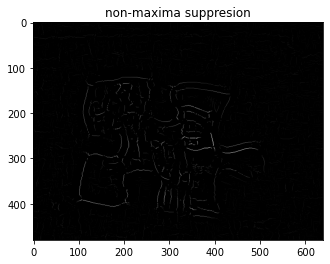

In [14]:
plt.imshow(thin_edges,cmap='gray')
plt.title("non-maxima suppresion")
plt.show()

# double thresholding

In [15]:
def threshold(img, lowThresholdRatio=0.1, highThresholdRatio=0.2):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [16]:
potentials = threshold(thin_edges)

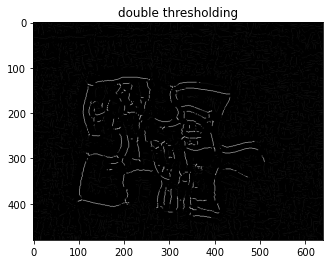

In [17]:
plt.imshow(potentials[0],cmap='gray')
plt.title("double thresholding")
plt.show()

# Track edges by Hysteresis

In [18]:
def hysteresis(img, weak, strong):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [19]:
final = hysteresis(potentials[0], potentials[1], potentials[2])

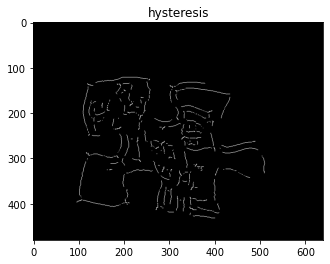

In [20]:
plt.imshow(final,cmap='gray')
plt.title("hysteresis")
plt.show()

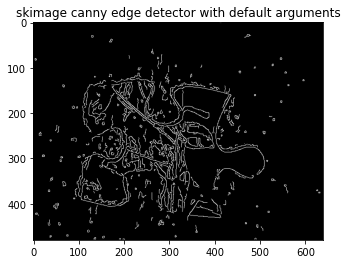

In [21]:
edges = feature.canny(image_gray)
plt.imshow(edges,cmap='gray')
plt.title("skimage canny edge detector with default arguments")
plt.show()

### The result from the skimage canny function with default arguments results in an image with lots of noise and some egdes detected and my final image and little to no noise especially on the background of the image, the edges are not perfectly defined, there is some edges that have been missed/skipped by the algorithm, I think this is due to some parts of the puzzle having colours too close to the background color so it was treated as a part of the background hence the 'missed' edges.

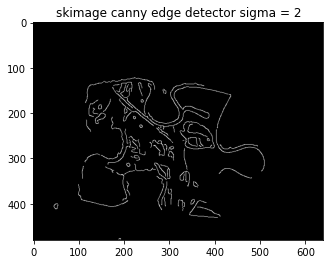

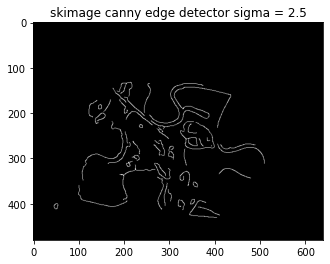

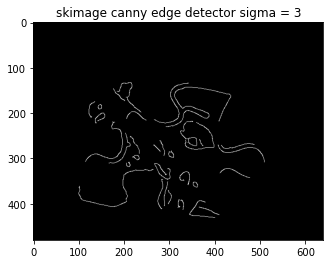

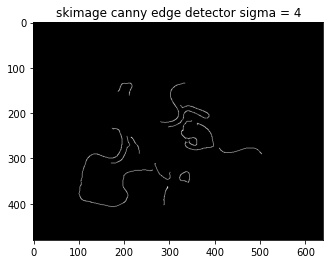

In [22]:
edges1 = feature.canny(image_gray, sigma=2)
plt.imshow(edges1,cmap='gray')
plt.title("skimage canny edge detector sigma = 2")
plt.show()

edges2 = feature.canny(image_gray, sigma=2.5)
plt.imshow(edges2,cmap='gray')
plt.title("skimage canny edge detector sigma = 2.5")
plt.show()

edges3 = feature.canny(image_gray, sigma=3)
plt.imshow(edges3,cmap='gray')
plt.title("skimage canny edge detector sigma = 3")
plt.show()

edges4 = feature.canny(image_gray, sigma=4)
plt.imshow(edges4,cmap='gray')
plt.title("skimage canny edge detector sigma = 4")
plt.show()

# plt.imshow(edges1,cmap='gray'),
# plt.title('sig=2'), plt.xticks([]), plt.yticks([])

### As I increased the value of sigma, the noise from the resulting imaging  decreased. But as the sigma value gets higher, the edges from the resulting image disappear and the puzzle gets 'chopped off'

# Harris corner detector

### Sobel filters

In [23]:
sobelx = cv.Sobel(image_gray,cv.CV_64F,1,0,ksize=9)
sobely = cv.Sobel(image_gray,cv.CV_64F,0,1,ksize=9)

(Text(0.5, 1.0, 'Sobel Y'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

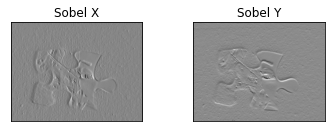

In [24]:
plt.subplot(2,2,1),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

### estimate size of gaussian filter

In [25]:
sigma = 1
truncate = 4.0
radius = math.floor(truncate*sigma +0.5)
size = 2*radius +1

### structure tensors

In [26]:
a = cv.GaussianBlur(sobelx**2,(size,size),0)
b = cv.GaussianBlur(sobelx*sobely,(size,size),0)
c = cv.GaussianBlur(sobely**2,(size,size),0)

In [27]:
k = 0.05

# determinant
det = a*c - b**2

# trace
trace = a + c

response = det - k*trace**2

In [28]:
# keeping local maxima only

In [29]:
height, width = image_gray.shape

window_size = 3
offset = (window_size)
offset

3

In [30]:
harris_response = []
cornerList = []
newImg = image_rgb.copy()
    
for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sxx = np.sum(a[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(c[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(b[y-offset:y+1+offset, x-offset:x+1+offset])
        
        #Find determinant and trace, use to get corner response
        det_2 = (Sxx * Syy) - (Sxy**2)
        trace_2 = Sxx + Syy
        r = det_2 - k*(trace_2**2)
        
        harris_response.append(r)
        cornerList.append([x, y, r])
        
#         if r > 0.05:
#             #print (x, y, r)
#             cornerList.append([x, y, r])
#             newImg.itemset((y, x, 0), 255)  #r
#             newImg.itemset((y, x, 1), 0)    #g
#             newImg.itemset((y, x, 2), 0)  #g

In [71]:
for r in cornerList:
    if r[2]/max(harris_response) > 0.05:
#         cornerList.append([x, y, r])
        newImg.itemset((y, x, 0), 100)  #b
        newImg.itemset((y, x, 1), 0)    #g
        newImg.itemset((y, x, 2), 255)  #r

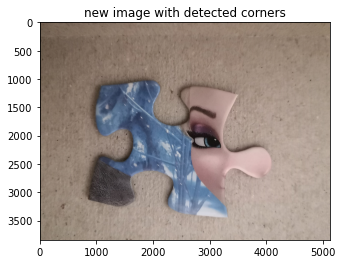

In [72]:
plt.imshow(newImg,cmap='gray')
plt.title("new image with detected corners")
plt.show()

### The implemented algorithm seems to have not detected any corners from the original image, I am really not sure/understanding why that is 

# Histogram of Oriented Gradients Descriptor

In [73]:
hog_image = cv.resize(image, (256, 192))
hog_gray = cv.cvtColor(hog_image, cv.COLOR_BGR2GRAY, 0)

In [74]:
def HoG(rgb_img, orientations =9, pixels_per_cell=8, cells_per_block=2):
    print(rgb_img.shape)
    print(rgb_img.shape[0]%pixels_per_cell)
    print(rgb_img.shape[1]%pixels_per_cell)
    print('cells per block * pixels per cell = ', cells_per_block * pixels_per_cell)

In [75]:
HoG(hog_image)

(192, 256, 3)
0
0
cells per block * pixels per cell =  16


In [76]:
b,g,r = cv.split(hog_image)

In [77]:
bx = cv.Sobel(b, cv.CV_32F, 1, 0, ksize=1)
by = cv.Sobel(b, cv.CV_32F, 0, 1, ksize=1)
gx = cv.Sobel(b, cv.CV_32F, 1, 0, ksize=1)
gy = cv.Sobel(b, cv.CV_32F, 0, 1, ksize=1)
rx = cv.Sobel(b, cv.CV_32F, 1, 0, ksize=1)
ry = cv.Sobel(b, cv.CV_32F, 0, 1, ksize=1)

In [101]:
# plt.subplot(2,2,1), plt.imshow(bx,cmap='gray')
# plt.title('bx'), plt.xticks([]), plt.yticks([])
# plt.subplot(2,2,2), plt.imshow(by,cmap='gray')
# plt.title('by'), plt.xticks([]), plt.yticks([])

In [102]:
# plt.subplot(2,2,1), plt.imshow(gx,cmap='gray')
# plt.title('gx'), plt.xticks([]), plt.yticks([])
# plt.subplot(2,2,2), plt.imshow(gy,cmap='gray')
# plt.title('gy'), plt.xticks([]), plt.yticks([])

In [78]:
bgr_x = np.dstack((bx,gx,rx))
bgr_y = np.dstack((by,gy,ry))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(Text(0.5, 1.0, 'bgr vertical'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

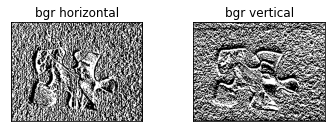

In [79]:
plt.subplot(2,2,1), plt.imshow(bgr_x,cmap='gray')
plt.title('bgr horizontal'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2), plt.imshow(bgr_y,cmap='gray')
plt.title('bgr vertical'), plt.xticks([]), plt.yticks([])

In [80]:
grad = np.hypot(bgr_x, bgr_y)
# grad = grad / grad.max() * 255
angle = np.arctan2(bgr_y, bgr_x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(Text(0.5, 1.0, 'angle image'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

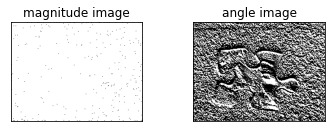

In [81]:
plt.subplot(2,2,1), plt.imshow(grad,cmap='gray')
plt.title('magnitude image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2), plt.imshow(angle,cmap='gray')
plt.title('angle image'), plt.xticks([]), plt.yticks([])

In [82]:
grad.shape

(192, 256, 3)

In [86]:
def take_axis(mag_image, angle_image):
    index = np.argmax(mag_image, axis=2)
    I,J = np.ogrid(mag_image.shape[0], mag_image.shape[1])
    take_magnitudes = mag_image[I,J, index]
    take_angles = angle_image[I,J, index]
    return take_magnitudes, take_angles
    

### Regardless of the implementation of these functions being incomplete for this lab (due to some confusion here and there)

### What I understand from all the labs we have done so far and how this will help us solve Tino's puzzle later is that we are now able to extract the foreground from the image, which gives us the puzzle, and we will match these puzzle pieces later. Detecting edges and corners also helps with the segmantation of the puzzle so that when we connect the puzzles later, they try to fit as perfectly as they can. 
### What I found tricky from the assessments is how the background color tends to blend with some parts of the puzzles making it difficult to detect the edges of the puzzle properly.

In [ ]:
!pyppeteer-install